In [19]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymr import cmr
from cymr import network
from cymr import parameters
from psifr import fr
from cfr import task

cfr_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(cfr_dir, 'cfr_eeg_mixed.csv')
pattern_file = os.path.join(cfr_dir, 'cfr_patterns.hdf5')
#model_name = 'cmr_fcf-loc-cat_ff-use'
model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat=1-B_rec_use=1'
fit_dir = os.path.join(cfr_dir, 'fits', 'v4', model_name)
param_file = os.path.join(fit_dir, 'parameters.json')

In [20]:
param_def = parameters.read_json(param_file)
results = pd.read_csv(os.path.join(fit_dir, 'fit.csv'), index_col=0)
subj_param = results.loc[1].to_dict()

In [55]:
patterns = network.load_patterns(pattern_file)
data = pd.read_csv(data_file)
#clean_data = data.query('repeat == 0 & ~intrusion')
subj_data = fr.filter_data(data, subjects=1, lists=9)
subj_data

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed
190,1,9,6,study,DAN RATHER,65,1,mixed,cel,3.0,0.634,mixed
191,1,9,7,study,VIENNA,492,1,mixed,loc,3.0,0.751,mixed
192,1,9,8,study,PLACE DE LA CONCORDE,424,1,mixed,loc,3.0,0.705,mixed
193,1,9,9,study,GREAT SALT LAKE,338,1,mixed,loc,2.0,0.716,mixed
194,1,9,10,study,SIENA,451,1,mixed,loc,3.0,0.579,mixed


In [49]:
merged.query('recall & repeat == 0 & ~intrusion')

,subject,list,item,input,output,study,recall,repeat,intrusion
5,1,9,DAN RATHER,6,13.0,True,True,0,False
6,1,9,VIENNA,7,5.0,True,True,0,False
9,1,9,SIENA,10,4.0,True,True,0,False
12,1,9,VEST,13,9.0,True,True,0,False
13,1,9,BOWLING BALL,14,8.0,True,True,0,False
14,1,9,CONDOLEEZZA RICE,15,7.0,True,True,0,False
15,1,9,BRUCE SPRINGSTEEN,16,6.0,True,True,0,False
16,1,9,UMA THURMAN,17,10.0,True,True,0,False
21,1,9,SAHARA,22,3.0,True,True,0,False
22,1,9,MICHAEL DOUGLAS,23,2.0,True,True,0,False


In [57]:
merged = fr.merge_free_recall(subj_data)
recall = fr.filter_data(subj_data, trial_type='recall')
#merged_recall = merged.query('recall & repeat == 0 & ~intrusion').copy()
merged_recall = merged.query('recall').copy()
merged_recall['trial_type'] = 'recall'
merged_recall['position'] = merged_recall['output'].astype('int')
merged_recall

,subject,list,item,input,output,study,recall,repeat,intrusion,trial_type,position
5,1,9,DAN RATHER,6,13.0,True,True,0,False,recall,13
6,1,9,VIENNA,7,5.0,True,True,0,False,recall,5
9,1,9,SIENA,10,4.0,True,True,0,False,recall,4
12,1,9,VEST,13,9.0,True,True,0,False,recall,9
13,1,9,BOWLING BALL,14,8.0,True,True,0,False,recall,8
14,1,9,CONDOLEEZZA RICE,15,7.0,True,True,0,False,recall,7
15,1,9,BRUCE SPRINGSTEEN,16,6.0,True,True,0,False,recall,6
16,1,9,UMA THURMAN,17,10.0,True,True,0,False,recall,10
21,1,9,SAHARA,22,3.0,True,True,0,False,recall,3
22,1,9,MICHAEL DOUGLAS,23,2.0,True,True,0,False,recall,2


In [65]:
merge_keys = ['subject', 'list', 'item', 'trial_type', 'position']
rmerged = pd.merge(subj_data, merged_recall, left_on=merge_keys, right_on=merge_keys, how='outer')
rmerged['intrusion'] = rmerged['intrusion'].fillna(False)
rmerged

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,input,output,study,recall,repeat,intrusion
0,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,NaN,NaN,NaN,NaN,NaN,False
1,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,NaN,NaN,NaN,NaN,NaN,False
2,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,NaN,NaN,NaN,NaN,NaN,False
3,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,NaN,NaN,NaN,NaN,NaN,False
4,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,NaN,NaN,NaN,NaN,NaN,False
5,1,9,6,study,DAN RATHER,65,1,mixed,cel,3.0,0.634,mixed,NaN,NaN,NaN,NaN,NaN,False
6,1,9,7,study,VIENNA,492,1,mixed,loc,3.0,0.751,mixed,NaN,NaN,NaN,NaN,NaN,False
7,1,9,8,study,PLACE DE LA CONCORDE,424,1,mixed,loc,3.0,0.705,mixed,NaN,NaN,NaN,NaN,NaN,False
8,1,9,9,study,GREAT SALT LAKE,338,1,mixed,loc,2.0,0.716,mixed,NaN,NaN,NaN,NaN,NaN,False
9,1,9,10,study,SIENA,451,1,mixed,loc,3.0,0.579,mixed,NaN,NaN,NaN,NaN,NaN,False


In [66]:
clean = rmerged.query('trial_type == "study" | (~intrusion & repeat == 0)')
clean.groupby('list').apply(lambda df: )

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,input,output,study,recall,repeat,intrusion
0,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,NaN,NaN,NaN,NaN,NaN,False
1,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,NaN,NaN,NaN,NaN,NaN,False
2,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,NaN,NaN,NaN,NaN,NaN,False
3,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,NaN,NaN,NaN,NaN,NaN,False
4,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,NaN,NaN,NaN,NaN,NaN,False
5,1,9,6,study,DAN RATHER,65,1,mixed,cel,3.0,0.634,mixed,NaN,NaN,NaN,NaN,NaN,False
6,1,9,7,study,VIENNA,492,1,mixed,loc,3.0,0.751,mixed,NaN,NaN,NaN,NaN,NaN,False
7,1,9,8,study,PLACE DE LA CONCORDE,424,1,mixed,loc,3.0,0.705,mixed,NaN,NaN,NaN,NaN,NaN,False
8,1,9,9,study,GREAT SALT LAKE,338,1,mixed,loc,2.0,0.716,mixed,NaN,NaN,NaN,NaN,NaN,False
9,1,9,10,study,SIENA,451,1,mixed,loc,3.0,0.579,mixed,NaN,NaN,NaN,NaN,NaN,False


In [71]:
import importlib
from cfr import task
importlib.reload(task)
labeled = task.label_clean_trials(data)
labeled

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean
0,1,2,1,study,SEAN PENN,228,1,mixed,cel,3.0,1.255,mixed,True
1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,3.0,1.040,mixed,True
2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,2.0,1.164,mixed,True
3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,2.0,0.829,mixed,True
4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,3.0,0.872,mixed,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31749,46,48,8,recall,CARROT TOP,46,3,mixed,cel,1.0,1.584,mixed,True
31750,46,48,9,recall,KIRSTEN DUNST,154,3,mixed,cel,3.0,1.391,mixed,True
31751,46,48,10,recall,ROBERT REDFORD,216,3,mixed,cel,3.0,0.961,mixed,True
31752,46,48,11,recall,MAYONNAISE,647,3,mixed,obj,3.0,1.989,mixed,True


In [72]:
labeled.query('clean').shape

(31307, 13)

In [74]:
model

In [67]:
from cymr import fit
fit.prepare_lists(clean)

({'input': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'item_index': [array([455, 454, 749, 571,  27,  65, 492, 424, 338, 451, 597, 618, 753,
          543,  61,  43, 246,  71, 717, 602, 371, 440, 178, 221])]},
 {'input': [array([23, 22, 21,  9,  6, 15, 14, 13, 12, 16,  5])]})

In [64]:
isstudy = rmerged['trial_type'] == 'study'
isclean = (rmerged['trial_type'] == 'recall') & (~rmerged['intrusion']) & (rmerged['repeat'] == 0)
clean = rmerged.loc[isstudy & isclean]
clean

TypeError: bad operand type for unary ~: 'float'

In [43]:
pd.merge?

Signature:
pd.merge(
    left,
    right,
    how: str = 'inner',
    on=None,
    left_on=None,
    right_on=None,
    left_index: bool = False,
    right_index: bool = False,
    sort: bool = False,
    suffixes=('_x', '_y'),
    copy: bool = True,
    indicator: bool = False,
    validate=None,
) -> 'DataFrame'
Docstring:
Merge DataFrame or named Series objects with a database-style join.

The join is done on columns or indexes. If joining columns on
columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
on indexes or indexes on a column or columns, the index will be passed on.

Parameters
----------
left : DataFrame
right : DataFrame or named Series
    Object to merge with.
how : {'left', 'right', 'outer', 'inner'}, default 'inner'
    Type of merge to be performed.

    * left: use only keys from left frame, similar to a SQL left outer join;
      preserve key order.
    * right: use only keys from right frame, similar to a SQL right outer join;
      pres

In [100]:
model = cmr.CMR()
sub_data = fr.filter_data(labeled, subjects=1)
state = model.record(sub_data, subj_param, param_def=param_def, patterns=patterns)
print(f'data:  {len(sub_data.query("clean"))}')
print(f'state: {len(state)}')

data:  1063
state: 1063


In [79]:
sub_data.loc[sub_data['clean'], 'state'] = state

In [84]:
sub_data.loc[0, 'state'].c.shape

(1286,)

In [126]:
state[24].f

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])

In [91]:
sub_data

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean,state
0,1,2,1,study,SEAN PENN,228,1,mixed,cel,3.0,1.255,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,3.0,1.040,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,2.0,1.164,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,2.0,0.829,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,3.0,0.872,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,1,48,8,recall,HOLLYWOOD,344,3,mixed,loc,3.0,0.653,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
1075,1,48,9,recall,WESTMINSTER ABBEY,499,3,mixed,loc,3.0,0.557,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
1076,1,48,10,recall,ELIZABETH TAYLOR,84,3,mixed,cel,2.0,0.477,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...
1077,1,48,11,recall,OLD FAITHFUL,407,3,mixed,loc,3.0,0.618,mixed,True,f:\ntask: 25 units\n item: 24 units\n st...


In [98]:
isinstance(sub_data.loc[1078, 'state'], float)

True

In [108]:
%matplotlib
c = np.array([s.c for s in state])
fig, ax = plt.subplots()
ax.matshow(c)

Using matplotlib backend: MacOSX


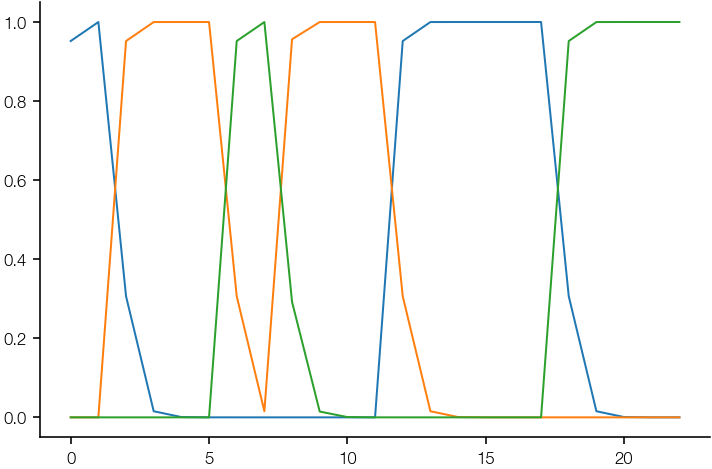

In [121]:
segment_ind = state[0].get_segment('c', 'cat', 'item')
ind = slice(*tuple(segment_ind))
plt.plot(c[:23, ind])

In [ ]:
state[0].get_segment

In [ ]:
state[0].get_segment

In [99]:
c_list = []
for i, state in sub_data['state'].items():
    if isinstance(state, float):
        continue
    c_list.append(state.c)
c = np.array(c_list)
c.shape

(1063, 1286)

In [13]:
lists = subj_data['list'].unique()
data_len = []
state_len = []
for l in lists:
    sub_data = fr.filter_data(subj_data, lists=l)
    state = model.record(sub_data, subj_param, param_def=param_def, patterns=patterns)
    data_len.append(len(sub_data))
    state_len.append(len(state))

In [27]:
pd.DataFrame({'data': data_len, 'state': state_len}, index=lists)

,data,state
2,38,38
3,42,42
4,33,33
6,37,37
8,35,35
9,37,35
10,32,30
11,31,31
13,33,33
16,29,29


In [13]:
len(state)

1093